In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

# Read in data

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [3]:
labeled_data

In [4]:
vars(labeled_data).keys()

dict_keys(['data', 'row_weight', 'label', 'pred', 'days', 'with_varsom', 'regobs_types', 'single', 'seasons', 'with_regions'])

In [5]:
labeled_data.data.shape

(13115, 291)

In [6]:
labeled_data.data.head()

region_id_3001 region_id_3002 region_id_3003 region_id_3004  \
                             0              0              0              0   
2017-11-23 3031            0.0            0.0            0.0            0.0   
           3034            0.0            0.0            0.0            0.0   
2017-12-02 3003            0.0            0.0            1.0            0.0   
           3007            0.0            0.0            0.0            0.0   
           3009            0.0            0.0            0.0            0.0   

                region_id_3005 region_id_3006 region_id_3007 region_id_3008  \
                             0              0              0              0   
2017-11-23 3031            0.0            0.0            0.0            0.0   
           3034            0.0            0.0            0.0            0.0   
2017-12-02 3003            0.0            0.0            0.0            0.0   
           3007            0.0            0.0            1.0            0.0   
           3009            0.0            0.0            0.0            0.0   

                region_id_3009 region_id_3010  ... wind_chg_dir_W  \
                             0              0  ...              0   
2017-11-23 3031            0.0            0.0  ...            0.0   
           3034            0.0            0.0  ...            0.0   
2017-12-02 3003            0.0            0.0  ...            0.0   
           3007            0.0            0.0  ...            0.0   
           3009            1.0            0.0  ...            0.0   

                wind_chg_dir_NW wind_chg_start_0 wind_chg_start_6  \
                              0                0                0   
2017-11-23 3031             0.0              0.0              0.0   
           3034             0.0              0.0              0.0   
2017-12-02 3003             0.0              0.0              0.0   
           3007             0.0              0.0              0.0   
           3009             0.0              0.0              0.0   

                wind_chg_start_12 wind_chg_start_18 temp_fl_start_0  \
                                0                 0               0   
2017-11-23 3031               0.0               0.0             0.0   
           3034               0.0               0.0             0.0   
2017-12-02 3003               0.0               0.0             0.0   
           3007               0.0               1.0             0.0   
           3009               0.0               1.0             0.0   

                temp_fl_start_6 temp_fl_start_12 temp_fl_start_18  
                              0                0                0  
2017-11-23 3031             1.0              0.0              0.0  
           3034             1.0              0.0              0.0  
2017-12-02 3003             0.0              0.0              0.0  
           3007             1.0              0.0              0.0  
           3009             1.0              0.0              0.0  

[5 rows x 291 columns]

# Data formatting, overall distributions

In [7]:
# first, drop regions
labeled_data.data = labeled_data.drop_regions().data

# then, rename indices
labeled_data.data = labeled_data.data.rename_axis(['date','region'])
labeled_data.label = labeled_data.label.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
labeled_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.label.columns.values]

# replace double underscores with single underscores
labeled_data.data.columns = [col.replace('__', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('__', '_') for col in labeled_data.label.columns.values]

# convert some columns in labels to type int for averaging
labeled_data.label['CLASS_problem_amount'] = labeled_data.label['CLASS_problem_amount'].astype(int)
labeled_data.label['CLASS_danger_level'] = labeled_data.label['CLASS_danger_level'].astype(int)

for column in labeled_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        labeled_data.label[column] = labeled_data.label[column].astype(int)

In [8]:
labeled_data.data.head()

danger_level_1  emergency_warning_1  problem_amount_1  \
date       region                                                          
2017-11-23 3031               4.0                  1.0               1.0   
           3034               4.0                  1.0               1.0   
2017-12-02 3003               1.0                  1.0               1.0   
           3007               2.0                  1.0               2.0   
           3009               2.0                  1.0               2.0   

                   problem_new-loose_1  problem_wet-loose_1  \
date       region                                             
2017-11-23 3031                    0.0                  0.0   
           3034                    0.0                  0.0   
2017-12-02 3003                    0.0                  0.0   
           3007                    0.0                  0.0   
           3009                    0.0                  0.0   

                   problem_new-slab_1  problem_drift-slab_1  \
date       region                                             
2017-11-23 3031                   0.0                   3.0   
           3034                   0.0                   3.0   
2017-12-02 3003                   0.0                   3.0   
           3007                   0.0                   3.0   
           3009                   0.0                   3.0   

                   problem_pwl-slab_1  problem_wet-slab_1  problem_glide_1  \
date       region                                                            
2017-11-23 3031                   0.0                 0.0              0.0   
           3034                   0.0                 0.0              0.0   
2017-12-02 3003                   0.0                 0.0              0.0   
           3007                   2.0                 0.0              0.0   
           3009                   2.0                 0.0              0.0   

                   ...  wind_chg_dir_W_0  wind_chg_dir_NW_0  \
date       region  ...                                        
2017-11-23 3031    ...               0.0                0.0   
           3034    ...               0.0                0.0   
2017-12-02 3003    ...               0.0                0.0   
           3007    ...               0.0                0.0   
           3009    ...               0.0                0.0   

                   wind_chg_start_0_0  wind_chg_start_6_0  \
date       region                                           
2017-11-23 3031                   0.0                 0.0   
           3034                   0.0                 0.0   
2017-12-02 3003                   0.0                 0.0   
           3007                   0.0                 0.0   
           3009                   0.0                 0.0   

                   wind_chg_start_12_0  wind_chg_start_18_0  \
date       region                                             
2017-11-23 3031                    0.0                  0.0   
           3034                    0.0                  0.0   
2017-12-02 3003                    0.0                  0.0   
           3007                    0.0                  1.0   
           3009                    0.0                  1.0   

                   temp_fl_start_0_0  temp_fl_start_6_0  temp_fl_start_12_0  \
date       region                                                             
2017-11-23 3031                  0.0                1.0                 0.0   
           3034                  0.0                1.0                 0.0   
2017-12-02 3003                  0.0                0.0                 0.0   
           3007                  0.0                1.0                 0.0   
           3009                  0.0                1.0                 0.0   

                   temp_fl_start_18_0  
date       region                      
2017-11-23 3031                   0.0  
           3034                   0.0  
2017-12-02 3003              

In [9]:
labeled_data.label.head()

CLASS_danger_level CLASS_emergency_warning CLASS_problem_1  \
date       region                                                               
2017-11-23 3031                     4               Ikke gitt      drift-slab   
           3034                     4               Ikke gitt      drift-slab   
2017-12-02 3003                     1               Ikke gitt      drift-slab   
           3007                     2               Ikke gitt        pwl-slab   
           3009                     2               Ikke gitt        pwl-slab   

                  CLASS_problem_2 CLASS_problem_3  CLASS_problem_amount  \
date       region                                                         
2017-11-23 3031                                                       1   
           3034                                                       1   
2017-12-02 3003                                                       1   
           3007                                                       1   
           3009                                                       1   

                  CLASS_drift-slab_cause  CLASS_drift-slab_dist  \
date       region                                                 
2017-11-23 3031                snowdrift                      3   
           3034                snowdrift                      3   
2017-12-02 3003                snowdrift                      1   
           3007                        0                      0   
           3009                        0                      0   

                   CLASS_drift-slab_dsize  CLASS_drift-slab_lev_fill  ...  \
date       region                                                     ...   
2017-11-23 3031                         3                          1  ...   
           3034                         3                          1  ...   
2017-12-02 3003                         2                          1  ...   
           3007                         0                          0  ...   
           3009                         0                          0  ...   

                   REAL_new-loose_lev_max  REAL_new-loose_lev_min  \
date       region                                                   
2017-11-23 3031                       0.0                     0.0   
           3034                       0.0                     0.0   
2017-12-02 3003                       0.0                     0.0   
           3007                       0.0                     0.0   
           3009                       0.0                     0.0   

                  REAL_new-slab_lev_max  REAL_new-slab_lev_min  \
date       region                                                
2017-11-23 3031                     0.0                    0.0   
           3034                     0.0                    0.0   
2017-12-02 3003                     0.0                    0.0   
           3007                     0.0                    0.0   
           3009                     0.0                    0.0   

                   REAL_pwl-slab_lev_max  REAL_pwl-slab_lev_min  \
date       region                                                 
2017-11-23 3031                      0.0                    0.0   
           3034                      0.0                    0.0   
2017-12-02 3003                      0.0                    0.0   
           3007                    400.0                    0.0   
           3009                    400.0                    0.0   

                   REAL_wet-loose_lev_max  REAL_wet-loose_lev_min  \
date       region                                                   
2017-11-23 3031                       0.0                     0.0   
           3034                       0.0                     0.0   
2017-12-02 3003                       0.0                     0.0   
           3007                       0.0                     0.0   
           3009                       0.0                     0.0   

              

In [10]:
labeled_data.data.mean().head(10)

danger_level_1          2.112390
emergency_warning_1     0.900419
problem_amount_1        1.574075
problem_new-loose_1     0.020892
problem_wet-loose_1     0.692871
problem_new-slab_1      0.449867
problem_drift-slab_1    1.682730
problem_pwl-slab_1      0.825848
problem_wet-slab_1      0.255051
problem_glide_1         0.121616
dtype: float64

In [11]:
features_and_labels = features = pd.concat([labeled_data.data, labeled_data.label], axis=1)
features_and_labels.shape

(13115, 314)

In [12]:
# drop columns that include text, create correlations matrix
only_numeric = features_and_labels.select_dtypes(include='number')
correlations = only_numeric.corr()

# shorten the x axis to only the labels
keep_cols = [col for col in labeled_data.label if col in correlations.columns]
drop_rows = list(set(correlations.columns) - set(keep_cols))
correlations = correlations.loc[drop_rows, keep_cols]

# there are some rows with only nan values, we can drop those here
empty_rows = [item for item in correlations.index if correlations.loc[item].isna().all() == True]
correlations.drop(empty_rows, inplace = True)

In [13]:
list(correlations.index)

['problem_pwl-slab_aspect_SW_1',
 'problem_pwl-slab_1',
 'wind_dir_SE_0',
 'problem_pwl-slab_lev_min_1',
 'problem_glide_lev_min_1',
 'emergency_warning_1',
 'wind_chg_start_6_0',
 'problem_wet-slab_prob_1',
 'problem_wet-slab_lev_fill_4_1',
 'problem_new-slab_prob_1',
 'problem_new-loose_aspect_E_1',
 'problem_pwl-slab_lev_fill_2_1',
 'problem_wet-slab_aspect_NE_1',
 'problem_new-loose_prob_1',
 'problem_glide_dsize_1',
 'problem_drift-slab_aspect_W_1',
 'temp_max_0',
 'wind_chg_dir_N_0',
 'problem_wet-loose_lev_fill_2_1',
 'problem_wet-slab_aspect_N_1',
 'wind_chg_dir_SE_0',
 'problem_pwl-slab_lev_max_1',
 'wind_dir_NW_0',
 'problem_glide_prob_1',
 'problem_drift-slab_trig_1',
 'problem_pwl-slab_aspect_S_1',
 'problem_pwl-slab_prob_1',
 'problem_wet-loose_prob_1',
 'problem_wet-loose_aspect_N_1',
 'wind_dir_E_0',
 'problem_glide_dist_1',
 'problem_glide_lev_fill_3_1',
 'wind_chg_start_12_0',
 'wind_change_speed_0',
 'problem_new-loose_aspect_W_1',
 'problem_pwl-slab_trig_1',
 'proble

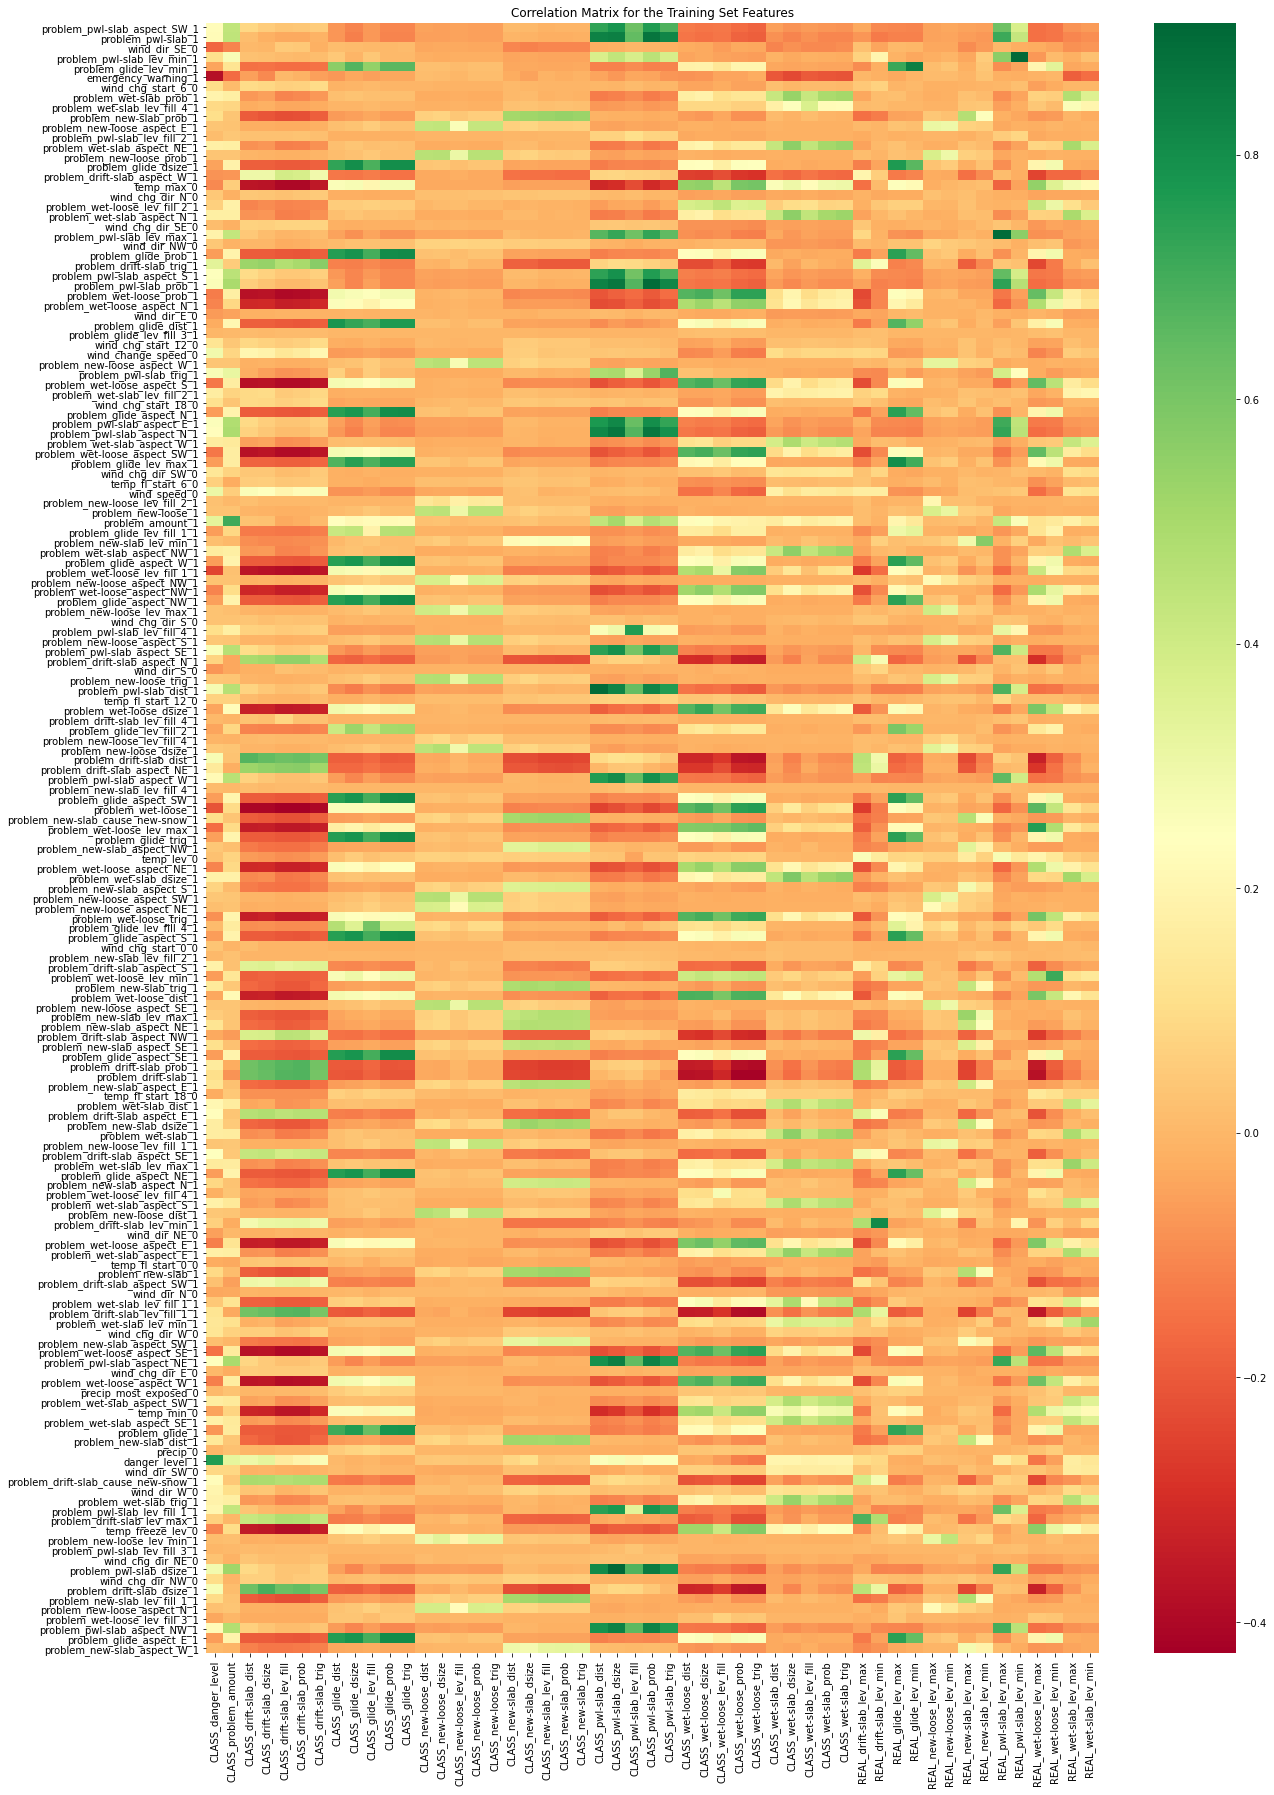

In [14]:
fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.index, cmap='RdYlGn', ax=ax)
ax.set_title('Correlation Matrix for the Training Set Features')

plt.show()

# Clustering data by region and time

I can look at how key variables are distributed for every region and all times. Then we can compare this to how how variables are distributed when clustering them by region or season. I am interested in understanding how certain input variables are correlated to the output variables of interest. This includes how different snow pack conditions vary with avlanche problems and danger level warnings, but also how these input and output variables change with time, across different regions, etc.

The data is formatted as a MultiIndex in Pandas. This means we can first subset by time, then by region ID.

## By time

In [15]:
# first, the overall means
label_means_all = pd.DataFrame(labeled_data.label.mean()[labeled_data.label.mean() != np.infty])
label_means_all.columns = ['all_seasons']
#label_means_all

In [16]:
# look at df from one day, there should be 21 regions
labeled_data.data.loc['2017-12-07'].shape

(21, 245)

In [17]:
labeled_data.data.loc['2017-12-07']

,danger_level_1,emergency_warning_1,problem_amount_1,problem_new-loose_1,problem_wet-loose_1,problem_new-slab_1,problem_drift-slab_1,problem_pwl-slab_1,problem_wet-slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
region,,,,,,,,,,,,,,,,,,,,,
3003,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3007,3.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3009,3.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3010,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3011,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3012,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3013,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3014,2.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3015,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
labeled_data.data.loc['2017-12-07'].mean().head(6)

danger_level_1         2.666667
emergency_warning_1    0.809524
problem_amount_1       1.952381
problem_new-loose_1    0.095238
problem_wet-loose_1    0.428571
problem_new-slab_1     0.952381
dtype: float64

In [19]:
dates_list = list(labeled_data.data.index.get_level_values(0))

# for date in dates_list:
#     print(date)

In [20]:
#find start and end dates for each season
season_start_1 = 0
season_end_1 = np.where(np.array(dates_list) == '2018-05-31')[0][-1]

season_start_2 = season_end_1 + 1
season_end_2 = np.where(np.array(dates_list) == '2019-05-31')[0][-1]

season_start_3 = season_end_2 + 1
season_end_3 = np.where(np.array(dates_list) == '2020-06-14')[0][-1]

season_start_4 = season_end_3 + 1

print('Season 1 dates: from {} until {}'.format(dates_list[season_start_1], dates_list[season_end_1]))
print('Season 2 dates: from {} until {}'.format(dates_list[season_start_2], dates_list[season_end_2]))
print('Season 3 dates: from {} until {}'.format(dates_list[season_start_3], dates_list[season_end_3]))
print('Season 4 dates: from {} until {}'.format(dates_list[season_start_4], dates_list[-1]))

Season 1 dates: from 2017-11-23 until 2018-05-31
Season 2 dates: from 2018-12-01 until 2019-05-31
Season 3 dates: from 2019-12-02 until 2020-06-14
Season 4 dates: from 2020-12-02 until 2021-01-12


In [21]:
first_data = labeled_data.data.iloc[:season_end_1+1]
second_data = labeled_data.data.iloc[season_start_2:season_end_2+1]
third_data = labeled_data.data.iloc[season_start_3:season_end_3+1]
fourth_data = labeled_data.data.iloc[season_start_4:]

first_labels = labeled_data.label.iloc[:season_end_1]
second_labels = labeled_data.label.iloc[season_start_2:season_end_2]
third_labels = labeled_data.label.iloc[season_start_3:season_end_3]
fourth_labels = labeled_data.label.iloc[season_start_4:]

In [22]:
print('Dataframe for 2017-2018 season has {} data points.'.format(len(first_data)))
print('Dataframe for 2018-2019 season has {} data points.'.format(len(second_data)))
print('Dataframe for 2019-2020 season has {} data points.'.format(len(third_data)))
print('Dataframe for 2020-2021 season has {} data points.'.format(len(fourth_data)))

Dataframe for 2017-2018 season has 3814 data points.
Dataframe for 2018-2019 season has 3906 data points.
Dataframe for 2019-2020 season has 4429 data points.
Dataframe for 2020-2021 season has 966 data points.


In [23]:
length_all_seasons = len(first_data) + len(second_data) + len(third_data) + len(fourth_data)
assert(length_all_seasons == len(labeled_data.data))

In [24]:
first_labels.head()

CLASS_danger_level CLASS_emergency_warning CLASS_problem_1  \
date       region                                                               
2017-11-23 3031                     4               Ikke gitt      drift-slab   
           3034                     4               Ikke gitt      drift-slab   
2017-12-02 3003                     1               Ikke gitt      drift-slab   
           3007                     2               Ikke gitt        pwl-slab   
           3009                     2               Ikke gitt        pwl-slab   

                  CLASS_problem_2 CLASS_problem_3  CLASS_problem_amount  \
date       region                                                         
2017-11-23 3031                                                       1   
           3034                                                       1   
2017-12-02 3003                                                       1   
           3007                                                       1   
           3009                                                       1   

                  CLASS_drift-slab_cause  CLASS_drift-slab_dist  \
date       region                                                 
2017-11-23 3031                snowdrift                      3   
           3034                snowdrift                      3   
2017-12-02 3003                snowdrift                      1   
           3007                        0                      0   
           3009                        0                      0   

                   CLASS_drift-slab_dsize  CLASS_drift-slab_lev_fill  ...  \
date       region                                                     ...   
2017-11-23 3031                         3                          1  ...   
           3034                         3                          1  ...   
2017-12-02 3003                         2                          1  ...   
           3007                         0                          0  ...   
           3009                         0                          0  ...   

                   REAL_new-loose_lev_max  REAL_new-loose_lev_min  \
date       region                                                   
2017-11-23 3031                       0.0                     0.0   
           3034                       0.0                     0.0   
2017-12-02 3003                       0.0                     0.0   
           3007                       0.0                     0.0   
           3009                       0.0                     0.0   

                  REAL_new-slab_lev_max  REAL_new-slab_lev_min  \
date       region                                                
2017-11-23 3031                     0.0                    0.0   
           3034                     0.0                    0.0   
2017-12-02 3003                     0.0                    0.0   
           3007                     0.0                    0.0   
           3009                     0.0                    0.0   

                   REAL_pwl-slab_lev_max  REAL_pwl-slab_lev_min  \
date       region                                                 
2017-11-23 3031                      0.0                    0.0   
           3034                      0.0                    0.0   
2017-12-02 3003                      0.0                    0.0   
           3007                    400.0                    0.0   
           3009                    400.0                    0.0   

                   REAL_wet-loose_lev_max  REAL_wet-loose_lev_min  \
date       region                                                   
2017-11-23 3031                       0.0                     0.0   
           3034                       0.0                     0.0   
2017-12-02 3003                       0.0                     0.0   
           3007                       0.0                     0.0   
           3009                       0.0                     0.0   

              

In [25]:
first_labels.tail()

CLASS_danger_level CLASS_emergency_warning CLASS_problem_1  \
date       region                                                               
2018-05-31 3028                     1               Ikke gitt       wet-loose   
           3029                     1               Ikke gitt       wet-loose   
           3031                     1               Ikke gitt       wet-loose   
           3032                     1               Ikke gitt       wet-loose   
           3034                     1               Ikke gitt       wet-loose   

                  CLASS_problem_2 CLASS_problem_3  CLASS_problem_amount  \
date       region                                                         
2018-05-31 3028                                                       1   
           3029                                                       1   
           3031                                                       1   
           3032                                                       1   
           3034                                                       1   

                  CLASS_drift-slab_cause  CLASS_drift-slab_dist  \
date       region                                                 
2018-05-31 3028                        0                      0   
           3029                        0                      0   
           3031                        0                      0   
           3032                        0                      0   
           3034                        0                      0   

                   CLASS_drift-slab_dsize  CLASS_drift-slab_lev_fill  ...  \
date       region                                                     ...   
2018-05-31 3028                         0                          0  ...   
           3029                         0                          0  ...   
           3031                         0                          0  ...   
           3032                         0                          0  ...   
           3034                         0                          0  ...   

                   REAL_new-loose_lev_max  REAL_new-loose_lev_min  \
date       region                                                   
2018-05-31 3028                       0.0                     0.0   
           3029                       0.0                     0.0   
           3031                       0.0                     0.0   
           3032                       0.0                     0.0   
           3034                       0.0                     0.0   

                  REAL_new-slab_lev_max  REAL_new-slab_lev_min  \
date       region                                                
2018-05-31 3028                     0.0                    0.0   
           3029                     0.0                    0.0   
           3031                     0.0                    0.0   
           3032                     0.0                    0.0   
           3034                     0.0                    0.0   

                   REAL_pwl-slab_lev_max  REAL_pwl-slab_lev_min  \
date       region                                                 
2018-05-31 3028                      0.0                    0.0   
           3029                      0.0                    0.0   
           3031                      0.0                    0.0   
           3032                      0.0                    0.0   
           3034                      0.0                    0.0   

                   REAL_wet-loose_lev_max  REAL_wet-loose_lev_min  \
date       region                                                   
2018-05-31 3028                    1400.0                     0.0   
           3029                    1200.0                     0.0   
           3031                    1200.0                     0.0   
           3032                    1500.0                     0.0   
           3034                    1200.0                     0.0   

              

In [26]:
season_labels = [first_labels, second_labels, third_labels, fourth_labels]
season_label_means = [df.mean() for df in season_labels]

In [27]:
label_means_seasons = pd.concat(season_label_means, axis=1)
label_means_seasons.columns = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']

drop_list = ['MULTI_wet-slab_aspect', 'MULTI_glide_aspect', 'MULTI_new-loose_aspect',
            'MULTI_new-slab_aspect', 'MULTI_pwl-slab_aspect', 'MULTI_wet-loose_aspect',
            'MULTI_wet-slab_aspect', 'MULTI_drift-slab_aspect', 'CLASS_glide_cause']

label_means_seasons = label_means_seasons.drop(index=drop_list)

In [28]:
reordered_idx = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', 'all_seasons']
compare_means = pd.concat([label_means_all, label_means_seasons], axis=1).T.loc[reordered_idx, :]
compare_means

,CLASS_danger_level,CLASS_problem_amount,CLASS_drift-slab_dist,CLASS_drift-slab_dsize,CLASS_drift-slab_lev_fill,CLASS_drift-slab_prob,CLASS_drift-slab_trig,CLASS_glide_dist,CLASS_glide_dsize,CLASS_glide_lev_fill,...,REAL_new-loose_lev_max,REAL_new-loose_lev_min,REAL_new-slab_lev_max,REAL_new-slab_lev_min,REAL_pwl-slab_lev_max,REAL_pwl-slab_lev_min,REAL_wet-loose_lev_max,REAL_wet-loose_lev_min,REAL_wet-slab_lev_max,REAL_wet-slab_lev_min
2017-2018,2.120378,1.653029,1.014162,1.153685,0.549961,1.651980,9.660372,0.033569,0.081301,0.057173,...,4.038815,0.524521,107.448204,2.386572,297.141359,43.063205,248.308419,46.236559,82.507212,15.892998
2018-2019,2.037132,1.513444,0.962612,1.107810,0.515493,1.567478,9.520102,0.025864,0.060948,0.034571,...,7.912932,1.792574,142.919334,7.631242,216.286812,26.248399,238.258643,51.241997,86.120359,22.688860
2019-2020,2.292457,1.655827,1.299232,1.540876,0.675474,2.064589,12.675248,0.150632,0.310976,0.279584,...,7.813911,7.429991,72.944896,72.944896,195.957543,178.771454,232.859079,226.490515,119.828365,106.820235
2020-2021,1.546584,1.144928,0.886128,1.044513,0.677019,2.053830,10.505176,0.000000,0.000000,0.000000,...,2.587992,2.587992,87.474120,87.474120,210.559006,203.416149,30.227743,29.296066,7.556936,6.625259
all_seasons,2.111170,1.574838,1.085398,1.262448,0.591308,1.795349,10.696531,0.068319,0.146778,0.121311,...,6.359131,3.385437,104.963782,34.037362,232.459016,95.676706,224.170797,107.403736,90.644300,47.929851


## Plotting seasonal and overall averages

Thank you to these two resources in helping me plot multiple dataframes side by side below:
- https://stackoverflow.com/questions/38106730/plotting-multiple-histograms-in-matplotlib-colors-or-side-by-side-bars
- https://www.thetopsites.net/article/53698519.shtml

And this excellent resource for rotating axis labels for multiple subplots:
- https://www.pythoncharts.com/2019/05/17/rotating-axis-labels/

In [29]:
def plot_label_dist(column_list, total_rows, total_cols, size, start, end, how='values', rotate=False):
    """
    Plot the distribution of values in the labels for a different column.
    
    Arguments:
       column_list(list): the list of columns you would like to plot from the different dataframes
       total_rows(int): number of subplots along y axis
       total_cols(int): number of subplots along x axis
       size(tuple): two integers, how big the Matplotlib plot should be
       start(int): column number to start plotting on
       end(int): column number to end plotting on
       how(str): either 'values' or 'means'
       rotate(bool): whether or not to rotate the x axis labels, mainly use for when axis labels are long strings
       
    Note:
        start - end should equal total_rows x total_cols
       
    Returns:
       None
    """
    row = 0
    col = 0

    fig, ax = plt.subplots(total_rows, total_cols, figsize=size)

    for i, column in enumerate(column_list[start:end]):
        
        if how == 'values':
            list_of_dfs = [first_labels[column].values, second_labels[column].values,
                           third_labels[column].values, fourth_labels[column].values,]
            hist_labels = ['first', 'second', 'third', 'fourth',]
        elif how == 'means':
            list_of_dfs = [compare_means.iloc[j][[col]] for j in range(5)]
            del list_of_dfs[3] #c urrently the fourth season does not have enough data and is skewing the graphs
            hist_labels = ['first', 'second', 'third', 'all']

        ax[row, col].hist(list_of_dfs, alpha=0.6, label=hist_labels)

        ax[row, col].set_title(column)
        ax[row, col].legend()
        
        # we need to draw the plot before using this method to rotate xtick labels
        if rotate == True:
            plt.draw()
            ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=30, ha='right')
        
        # update row and column for to move to next plot
        if(col < 2):
            col += 1
        else: 
            col = 0

        if((i+1) % 3 == 0 and i > 0):
            row += 1

    plt.show()

### Plot labels by means

Let's look at everything but the avalanche problems for now.

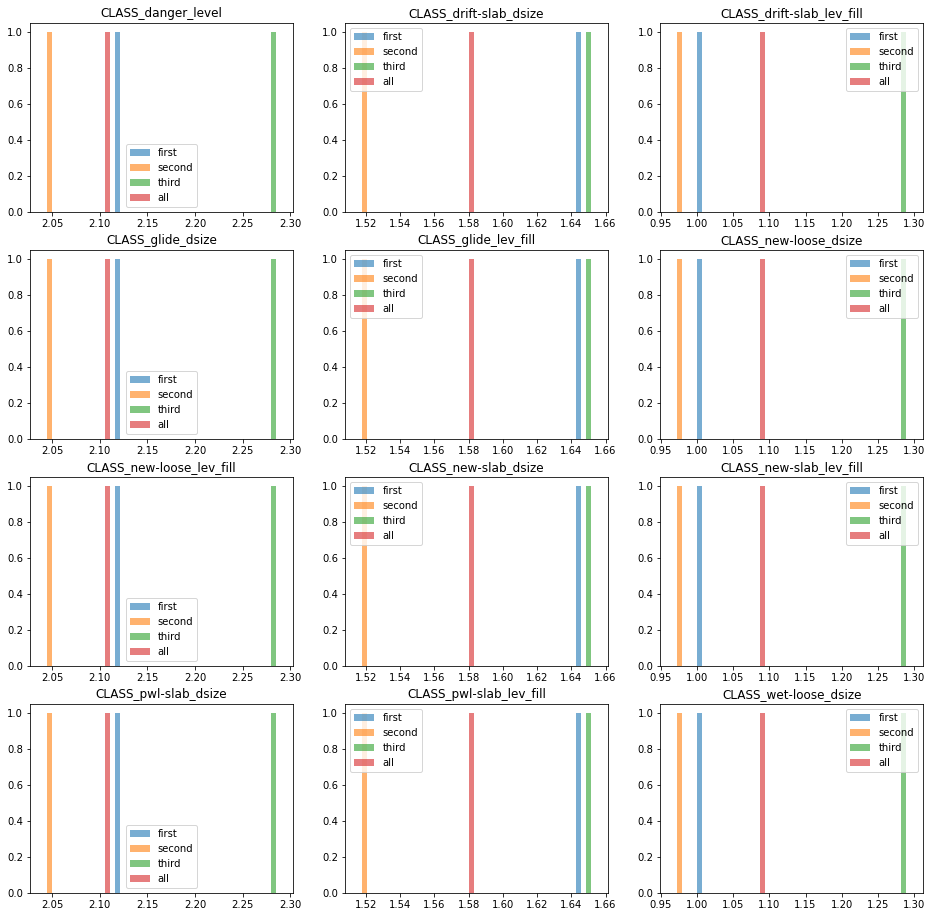

In [30]:
col_list = [column for column in compare_means.columns if 'lev' in column or 'dsize' in column]
plot_label_dist(col_list, 4, 3, (16, 16), 0, 12, 'means')

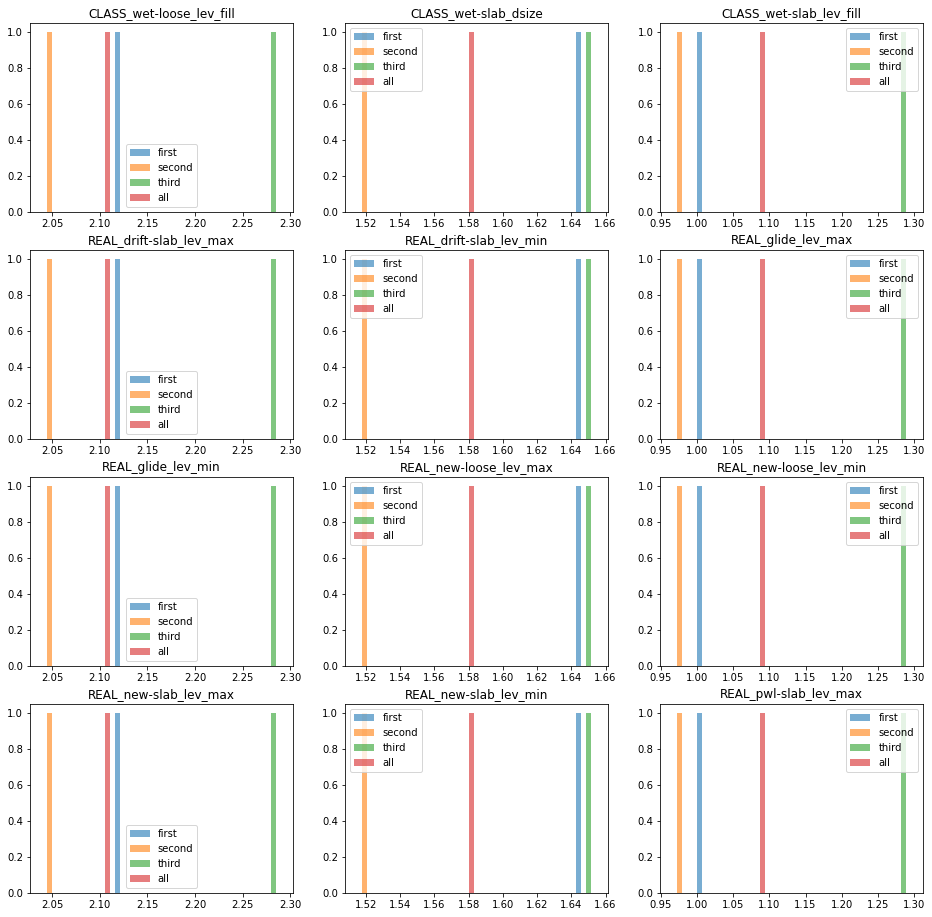

In [31]:
plot_label_dist(col_list, 4, 3, (16, 16), 12, 24, 'means')

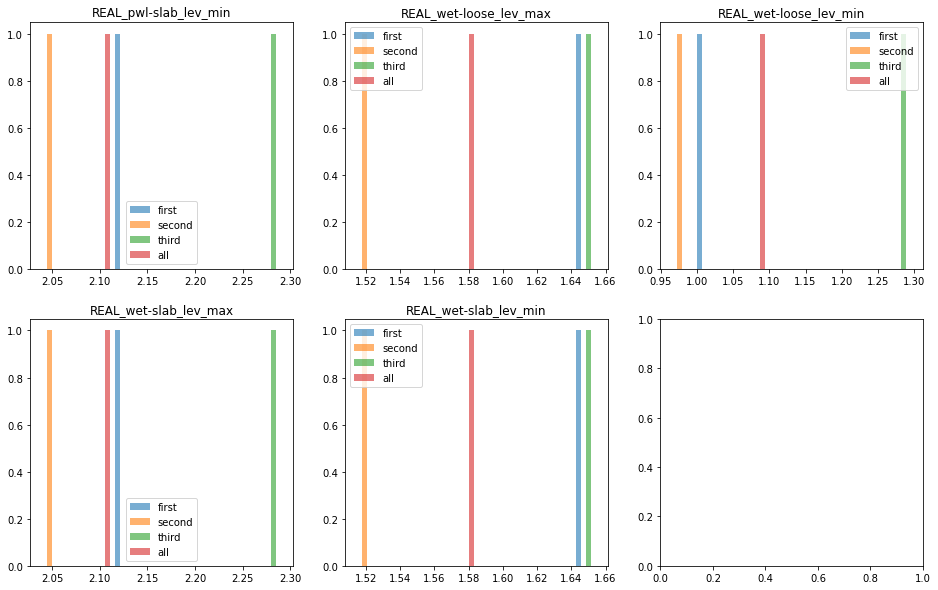

In [32]:
plot_label_dist(col_list, 2, 3, (16, 10), 24, len(col_list), 'means')

### Plot labels by distribution of values
Instead of just plotting the means, we can get a better look at our data labels by plotting the distribution of values.

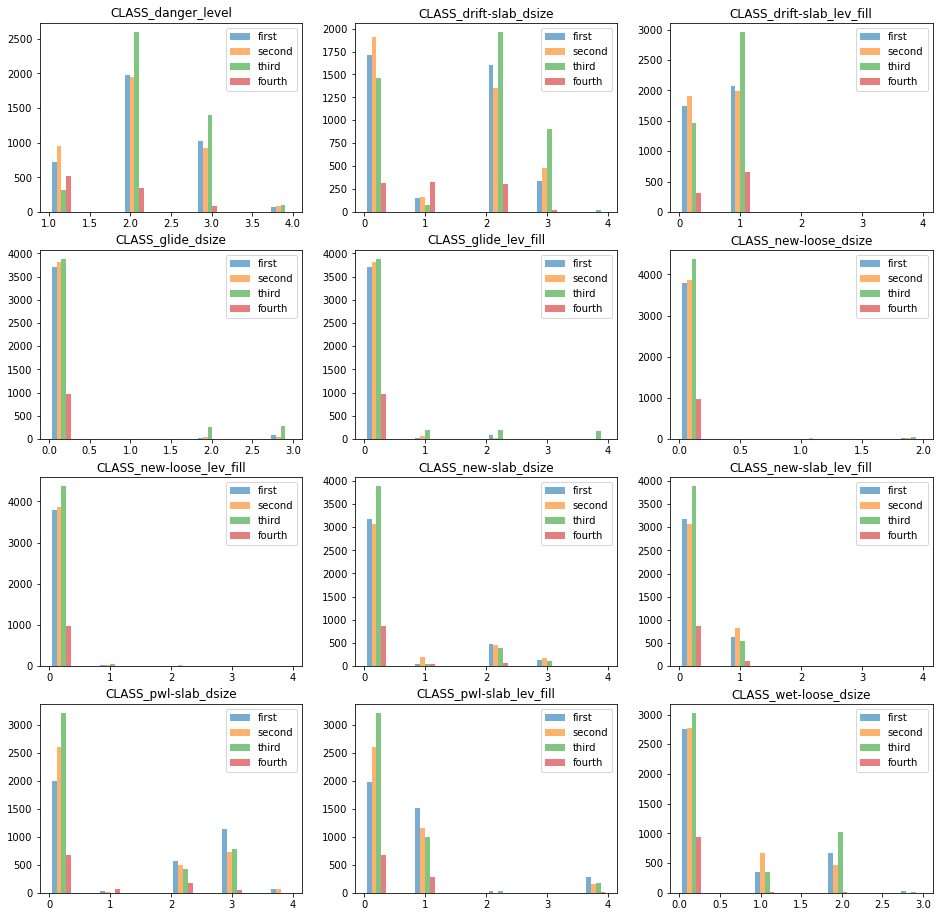

In [33]:
plot_label_dist(col_list, 4, 3, (16, 16), 0, 12)

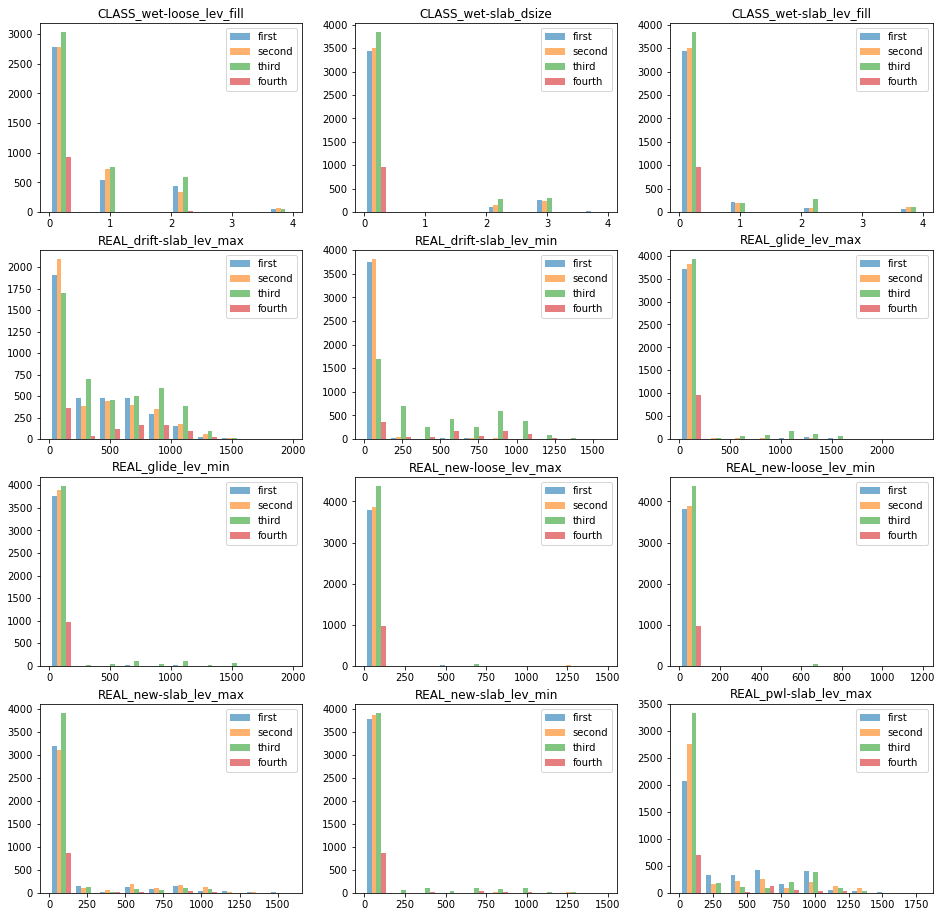

In [34]:
plot_label_dist(col_list, 4, 3, (16, 16), 12, 24)

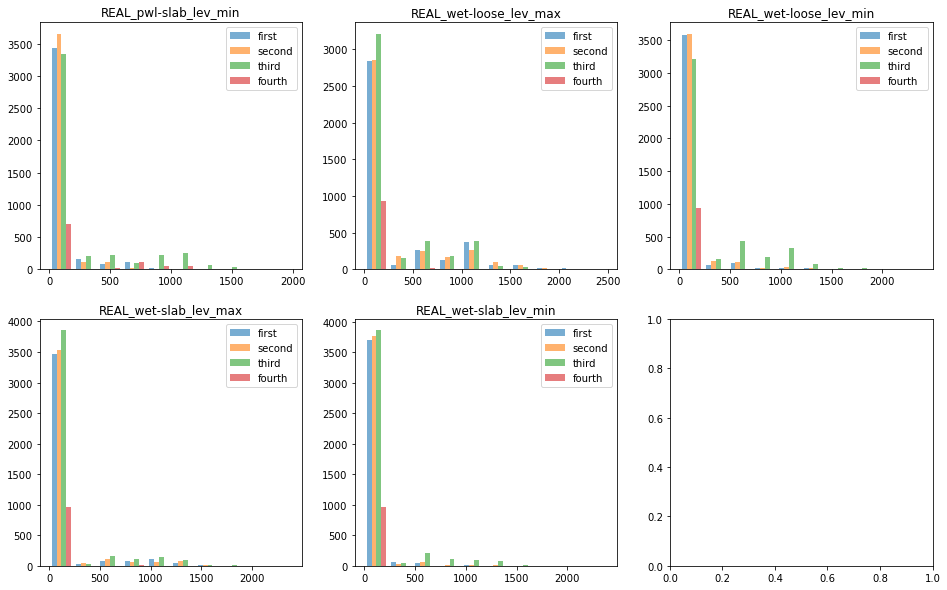

In [35]:
plot_label_dist(col_list, 2, 3, (16, 10), 24, len(col_list))

So season 3 seems to be skewing the average on several variables, the the labels are heavily skewed towards 0 in each category. This is going to be difficult for our machine learning model to handle.

Next, we can look at how often a given problem happens during a given season to see if we can reasonably expect to predict them (or if they are just noise).

In [36]:
problem_list = [problem for problem in first_labels.columns.values if 'prob' in problem]
problem_list

['CLASS_problem_1',
 'CLASS_problem_2',
 'CLASS_problem_3',
 'CLASS_problem_amount',
 'CLASS_drift-slab_prob',
 'CLASS_glide_prob',
 'CLASS_new-loose_prob',
 'CLASS_new-slab_prob',
 'CLASS_pwl-slab_prob',
 'CLASS_wet-loose_prob',
 'CLASS_wet-slab_prob']

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator


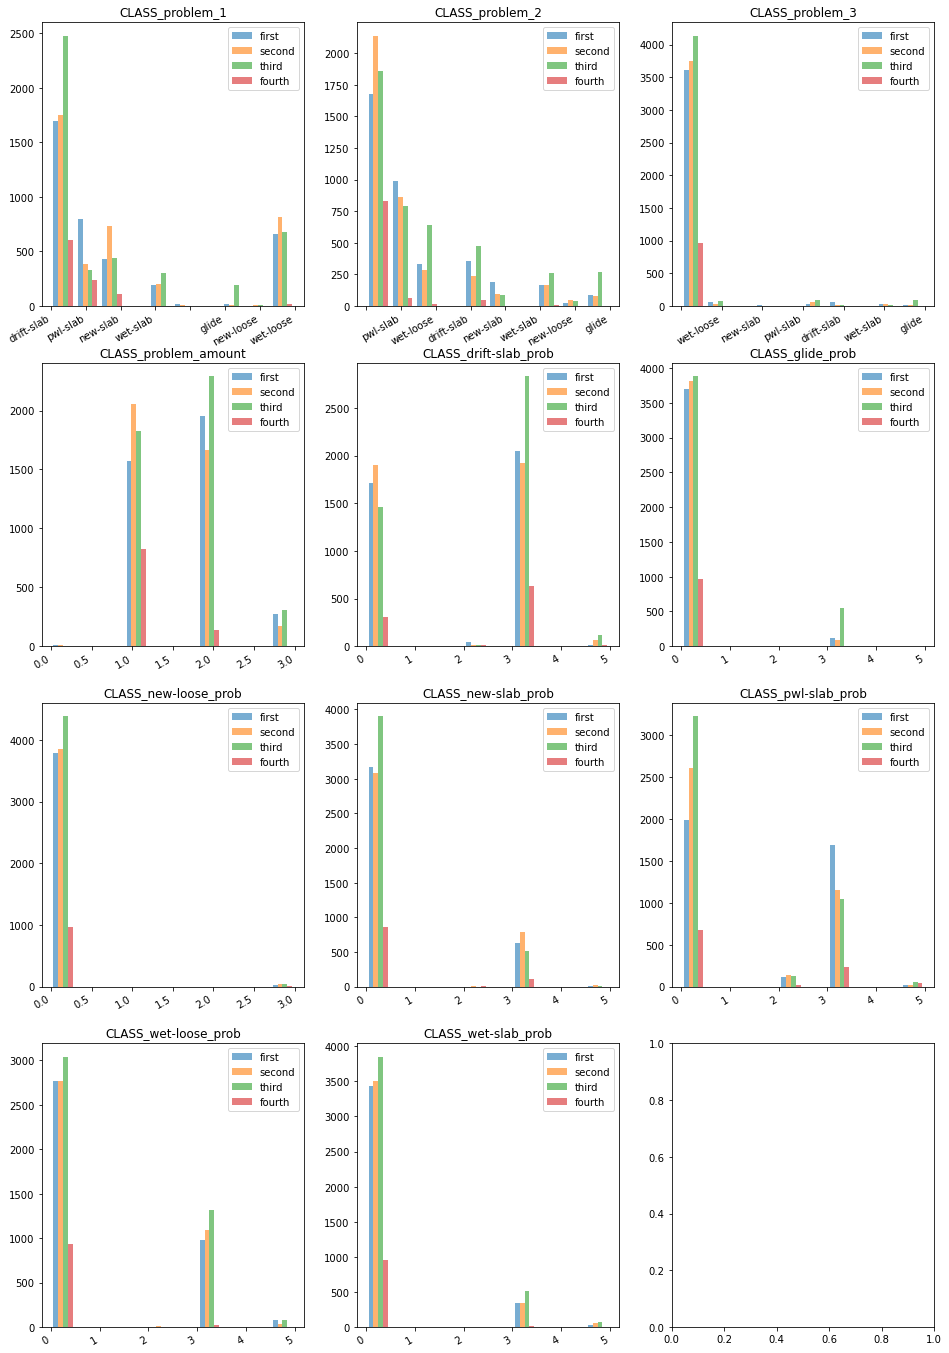

In [37]:
col_list = problem_list
plot_label_dist(col_list, 4, 3, (16, 24), 0, len(problem_list), rotate=True)

## By region

To group by regions, we first need to reorder the indices of the MultiIndex object.

In [34]:
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [35]:
regions_list = list(np.unique([region for region in labeled_data.data.loc['2017-12-07'].index]))
regions_list

[3003,
 3007,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3022,
 3023,
 3024,
 3027,
 3028,
 3029,
 3031,
 3032,
 3034,
 3035]

In [36]:
region_3003 = regions.loc[3003]
region_3003

,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
date,,,,,,,,,,,,,,,,,,,,,
2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-08,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-09,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-10,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-11,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,3.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-10,2.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
region_3003.tail()

,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
date,,,,,,,,,,,,,,,,,,,,,
2021-01-08,3.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-10,2.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-11,2.0,2.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-12,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
label_3003 = labels.loc[3003]
label_3003

,CLASS__danger_level,CLASS__emergency_warning,CLASS__problem_1,CLASS__problem_2,CLASS__problem_3,CLASS__problem_amount,CLASS_drift-slab_cause,CLASS_drift-slab_dist,CLASS_drift-slab_dsize,CLASS_drift-slab_lev_fill,...,REAL_new-loose_lev_max,REAL_new-loose_lev_min,REAL_new-slab_lev_max,REAL_new-slab_lev_min,REAL_pwl-slab_lev_max,REAL_pwl-slab_lev_min,REAL_wet-loose_lev_max,REAL_wet-loose_lev_min,REAL_wet-slab_lev_max,REAL_wet-slab_lev_min
date,,,,,,,,,,,,,,,,,,,,,
2017-12-07,2,Ikke gitt,drift-slab,,,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-08,2,Ikke gitt,drift-slab,,,1,new-snow,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-09,2,Ikke gitt,drift-slab,,,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-10,2,Ikke gitt,drift-slab,,,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-11,2,Ikke gitt,drift-slab,,,1,new-snow,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,3,Ikke gitt,drift-slab,pwl-slab,,2,new-snow,2,3,1,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
2021-01-09,2,Ikke gitt,drift-slab,pwl-slab,,2,new-snow,2,2,1,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
2021-01-10,2,Ikke gitt,drift-slab,pwl-slab,,2,new-snow,2,2,1,...,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0


In [39]:
index1 = list(set([column[0] for column in region_3003.columns]))

print(len(index1))
index1

7


['e', 'p', 'a', 'r', 't', 'w', 'd']

In [40]:
label_3003.columns

Index(['CLASS__danger_level', 'CLASS__emergency_warning', 'CLASS__problem_1',
       'CLASS__problem_2', 'CLASS__problem_3', 'CLASS__problem_amount',
       'CLASS_drift-slab_cause', 'CLASS_drift-slab_dist',
       'CLASS_drift-slab_dsize', 'CLASS_drift-slab_lev_fill',
       'CLASS_drift-slab_prob', 'CLASS_drift-slab_trig', 'CLASS_glide_cause',
       'CLASS_glide_dist', 'CLASS_glide_dsize', 'CLASS_glide_lev_fill',
       'CLASS_glide_prob', 'CLASS_glide_trig', 'CLASS_new-loose_cause',
       'CLASS_new-loose_dist', 'CLASS_new-loose_dsize',
       'CLASS_new-loose_lev_fill', 'CLASS_new-loose_prob',
       'CLASS_new-loose_trig', 'CLASS_new-slab_cause', 'CLASS_new-slab_dist',
       'CLASS_new-slab_dsize', 'CLASS_new-slab_lev_fill',
       'CLASS_new-slab_prob', 'CLASS_new-slab_trig', 'CLASS_pwl-slab_cause',
       'CLASS_pwl-slab_dist', 'CLASS_pwl-slab_dsize',
       'CLASS_pwl-slab_lev_fill', 'CLASS_pwl-slab_prob', 'CLASS_pwl-slab_trig',
       'CLASS_wet-loose_cause', 'CLASS_wet-loo

**TO DO**
- look at seasons distribution (clustered by year) of danger level, avalanche problem, snow distribution, temperature distribution, etc.

- then do the same thing for clusters of region: how are danger level, avalanche problem, snow and temperature distribution affected (so all years lumped into one dataset)

Now we could average over columns, sum, etc. We could try to count, as well, for histograms.

Could we embed a picture of Norway, and then map these averages or sums onto the avlanche regions? Are the avalanche regions in a format that GeoPandas can read in?